All Packages I might need

In [1]:
import numpy as np
from numpy.random import randn

import pandas as pd
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix

import math as m

import time as t

In [2]:
NFL_DF=pd.DataFrame(pd.read_csv('NFL_Scores_Clean.csv'))
NFL_DF=NFL_DF[NFL_DF.Type=='Regular Season']

In [3]:
def Result(F,A):
    if F==A:
        return 0.5
    elif F>A:
        return 1
    else:
        return 0

In [4]:
NFL_DF_Home=NFL_DF.drop(['Visitor','OT','Type'],axis=1)
NFL_DF_Home=NFL_DF_Home.rename(columns={'Home':'Team','VisitorScore':'HomeAgainst','HomeScore':'HomeFor'})
NFL_DF_Home['For']=NFL_DF_Home.HomeFor
NFL_DF_Home['Against']=NFL_DF_Home.HomeAgainst
NFL_DF_Home['HomeResult']= NFL_DF_Home.apply(lambda row: Result(row['HomeFor'],row['HomeAgainst']),axis=1)
NFL_DF_Home['Result']=NFL_DF_Home.HomeResult
NFL_DF_Home['AwayFor']=np.NaN #empty road columns
NFL_DF_Home['AwayAgainst']=np.NaN
NFL_DF_Home['AwayResult']=np.NaN

NFL_DF_Away=NFL_DF.drop(['Home','OT','Type'],axis=1)
NFL_DF_Away=NFL_DF_Away.rename(columns={'Visitor':'Team','VisitorScore':'AwayFor','HomeScore':'AwayAgainst'})
NFL_DF_Away['For']=NFL_DF_Away.AwayFor
NFL_DF_Away['Against']=NFL_DF_Away.AwayAgainst
NFL_DF_Away['AwayResult']=NFL_DF_Away.apply(lambda row: Result(row['AwayFor'],row['AwayAgainst']),axis=1)
NFL_DF_Away['Result']=NFL_DF_Away.AwayResult
NFL_DF_Away['HomeFor']=np.NaN #empty home columns
NFL_DF_Away['HomeAgainst']=np.NaN
NFL_DF_Away['HomeResult']=np.NaN

NFL_DF_All=NFL_DF_Away.append(NFL_DF_Home,ignore_index=True)

In [5]:
NFL_Results=NFL_DF_All.groupby(['Season','Team']).mean()

In [6]:
#How frequent are ties?
NFL_DF_All[NFL_DF_All['Result']==.5].Result.count()/NFL_DF_All['Result'].count()

NFL_DF_All[NFL_DF_All['Result']==.5].Result.count(), NFL_DF_All['Result'].count()

(16, 5120)

In [7]:
#Home win percentage
NFL_DF_All.HomeResult.mean(),NFL_DF_All.AwayResult.mean()

(0.566796875, 0.433203125)

In [8]:
test2=[]
for p in np.linspace(0,5,21):
    NFL_Results['PythagWin']=NFL_Results.For**p/(NFL_Results.Against**p+NFL_Results.For**p)
    NFL_Results['SqErr']=(NFL_Results.Result-NFL_Results.PythagWin)**2
    test2.append({'p':p,'SqErr':sum(NFL_Results.SqErr)})
test2_df=pd.DataFrame(test2)
test2_df

,p,SqErr
0,0.00,11.769531
1,0.25,9.904115
2,0.50,8.246418
3,0.75,6.800401
4,1.00,5.565072
5,1.25,4.534978
6,1.50,3.700920
7,1.75,3.050810
8,2.00,2.570540
9,2.25,2.244811


I will use p=2.75. Win%=PF^2.75/(PF^2.75+PA^2.75)

In [9]:
NFL_DF=NFL_DF_All.groupby(['Season','Team']).mean()

All single-computation commands

In [10]:
NFL_DF.reset_index(level=0, inplace=True)
p_NFL=2.75

NFL_DF['PythagHome']=NFL_DF.apply(lambda x: x['HomeFor']**p_NFL/(x['HomeFor']**p_NFL+x['HomeAgainst']**p_NFL),axis=1)
NFL_DF['PythagAway']=NFL_DF.apply(lambda x: x['AwayFor']**p_NFL/(x['AwayFor']**p_NFL+x['AwayAgainst']**p_NFL),axis=1)
NFL_DF['Pythag']=NFL_DF.apply(lambda x: x['For']**p_NFL/(x['For']**p_NFL+x['Against']**p_NFL),axis=1)

NFL_DF["SeasRank"] = NFL_DF.groupby(['Season'])["Pythag"].rank(method='first', ascending=False)

NFL_Averages=NFL_DF.groupby('SeasRank').mean()

HF_Avg=NFL_DF.HomeFor.mean()
HA_Avg=NFL_DF.HomeAgainst.mean()
Pts_Avg=NFL_DF.For.mean()
HF_Avg,HA_Avg,Pts_Avg

NFL_Sched=pd.DataFrame(pd.read_excel('NFL_Schedule.xlsx'))
NFL_Sched=NFL_Sched.drop(['VisitConfDiv','HomeConfDiv'],axis=1)
NFL_Sched.head()

def Sim(F,A):
    r=np.random.rand()
    p=F**p_NFL/(F**p_NFL+A**p_NFL)
    if r<p:
        return 1
    elif r>p:
        return 0
    else:
        return 0.5
    
def FullGameSim(HF,HA,AF,AA,Avg_HF,Avg_HA):
    HF_Adj=(HF*AA)/Avg_HF
    AF_Adj=(AF*HA)/Avg_HA
    g=Sim(HF_Adj,AF_Adj)
    return g,HF_Adj,AF_Adj

All iterative simulations

In [11]:
t_start=t.time()
n_sim=10
Results=[]
for sim in range(0,n_sim):
    NFL_Ranks=pd.DataFrame(data={'TeamID':NFL_Sched['HomeID'].unique(),'TeamRank':np.random.rand(32),'Conf':np.NAN,'Div':np.NAN})
    NFL_Ranks.TeamRank=NFL_Ranks.TeamRank.rank(method='first', ascending=False) #replace randoms with ranks
    
    for i in range(0,32):
        NFL_Ranks.iloc[i,2]=NFL_Sched.loc[NFL_Sched['HomeID']==NFL_Ranks.iloc[i,0]].iloc[0,3]
        NFL_Ranks.iloc[i,3]=NFL_Sched.loc[NFL_Sched['HomeID']==NFL_Ranks.iloc[i,0]].iloc[0,4]

    NFL_Sched['AwayRank']=NFL_Sched.apply(lambda x: NFL_Ranks.loc[NFL_Ranks['TeamID'] == x['VisitID']].iloc[0,1] ,axis=1)
    NFL_Sched['HomeRank']=NFL_Sched.apply(lambda x: NFL_Ranks.loc[NFL_Ranks['TeamID'] == x['HomeID']].iloc[0,1] ,axis=1)

    NFL_Sched['HomeResult']=NFL_Sched.apply(lambda x: FullGameSim(
        NFL_Averages.iloc[int(x['HomeRank']-1),7]
        ,NFL_Averages.iloc[int(x['HomeRank']-1),8]
        ,NFL_Averages.iloc[int(x['AwayRank']-1),1]
        ,NFL_Averages.iloc[int(x['AwayRank']-1),2]
        ,HF_Avg,HA_Avg)[0], axis=1)

    NFL_Ranks['Result']=np.NAN
    for i in range(1,33):
        NFL_Ranks.iloc[i-1,4]=(NFL_Sched.groupby('HomeRank').mean().HomeResult[NFL_Ranks.iloc[i-1,1]]+
                                   (1-NFL_Sched.groupby('AwayRank').mean().HomeResult[NFL_Ranks.iloc[i-1,1]]))/2
    NFL_Ranks['Wins']=16*NFL_Ranks['Result']
    NFL_Ranks['Losses']=16*(1-NFL_Ranks['Result'])

    NFL_Ranks['NFLRank']=NFL_Ranks.Result.rank(method='first', ascending=False)
    NFL_Ranks['ConfRank']=NFL_Ranks.groupby('Conf').Result.rank(method='first', ascending=False)
    NFL_Ranks['DivRank']=NFL_Ranks.groupby(['Conf','Div']).Result.rank(method='first', ascending=False)
    NFL_Ranks['ConfSeed']=np.where(NFL_Ranks.DivRank==1,0,100)+NFL_Ranks.ConfRank
    NFL_Ranks['ConfSeed']=NFL_Ranks.groupby('Conf').ConfSeed.rank(method='first', ascending=True)
    NFL_Ranks['PlayoffResult']='None' #Say "none" for each team. Playoff teams updated later
    NFL_Ranks['Sim']=sim #save run number
    
    NFL_Post_Sched=pd.read_excel('NFL_playoffs.xlsx')
    #Playoff Simulations
    NFL_Post_Sched['Result']=np.NAN

    #Byes
    NFL_Post_Sched.iloc[4,6]=NFL_Ranks.loc[(NFL_Ranks.Conf==NFL_Post_Sched.iloc[4,0])&
                                           (NFL_Ranks.ConfSeed==NFL_Post_Sched.iloc[4,3])].iloc[0,0] #AFC 1-seed
    NFL_Post_Sched.iloc[5,6]=NFL_Ranks.loc[(NFL_Ranks.Conf==NFL_Post_Sched.iloc[5,0])&
                                           (NFL_Ranks.ConfSeed==NFL_Post_Sched.iloc[5,3])].iloc[0,0] #AFC 2-seed
    NFL_Post_Sched.iloc[6,6]=NFL_Ranks.loc[(NFL_Ranks.Conf==NFL_Post_Sched.iloc[6,0])&
                                           (NFL_Ranks.ConfSeed==NFL_Post_Sched.iloc[6,3])].iloc[0,0] #AFC 1-seed
    NFL_Post_Sched.iloc[7,6]=NFL_Ranks.loc[(NFL_Ranks.Conf==NFL_Post_Sched.iloc[7,0])&
                                           (NFL_Ranks.ConfSeed==NFL_Post_Sched.iloc[7,3])].iloc[0,0] #AFC 2-seed
    #AFCWC1
    r=0
    NFL_Post_Sched.iloc[r,6]=NFL_Ranks.loc[(NFL_Ranks.Conf==NFL_Post_Sched.iloc[r,0])&
                                           (NFL_Ranks.ConfSeed==NFL_Post_Sched.iloc[r,3])].iloc[0,0] #Fill in HigherSeedID
    NFL_Post_Sched.iloc[r,7]=NFL_Ranks.loc[(NFL_Ranks.Conf==NFL_Post_Sched.iloc[r,0])&
                                           (NFL_Ranks.ConfSeed==NFL_Post_Sched.iloc[r,4])].iloc[0,0] #Fill in LowerSeedID
    HighRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,7]].iloc[0,1] #Lower Seed Rank
    g=FullGameSim(
        NFL_Averages.iloc[int(HighRank-1),7]
        ,NFL_Averages.iloc[int(HighRank-1),8]
        ,NFL_Averages.iloc[int(LowRank-1),1]
        ,NFL_Averages.iloc[int(LowRank-1),2]
        ,HF_Avg,HA_Avg)[0]
    if g==1:
        NFL_Post_Sched.iloc[r,8]='Higher' #Higher seed won
        NFL_Post_Sched.iloc[5,7]=NFL_Post_Sched.iloc[r,6] #3-seed advances to play 2-seed
        NFL_Post_Sched.iloc[5,4]=NFL_Post_Sched.iloc[r,3] #Write their seed
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,7],'PlayoffResult']='WC' #Note that lower seed lost in WC round
        AFC_Win=3 #Save seed
    else:
        NFL_Post_Sched.iloc[r,8]='Lower'
        NFL_Post_Sched.iloc[4,7]=NFL_Post_Sched.iloc[r,7] #6-seed advances to play 1-seed
        NFL_Post_Sched.iloc[4,4]=NFL_Post_Sched.iloc[r,4] #Write their seed
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,6],'PlayoffResult']='WC' #Note that higher seed lost in WC round
        AFC_Win=6

    #AFCWC2
    r=r+1
    NFL_Post_Sched.iloc[r,6]=NFL_Ranks.loc[(NFL_Ranks.Conf==NFL_Post_Sched.iloc[r,0])&
                                           (NFL_Ranks.ConfSeed==NFL_Post_Sched.iloc[r,3])].iloc[0,0] #Fill in HigherSeedID
    NFL_Post_Sched.iloc[r,7]=NFL_Ranks.loc[(NFL_Ranks.Conf==NFL_Post_Sched.iloc[r,0])&
                                           (NFL_Ranks.ConfSeed==NFL_Post_Sched.iloc[r,4])].iloc[0,0] #Fill in LowerSeedID
    HighRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,7]].iloc[0,1] #Lower Seed Rank
    g=FullGameSim(
        NFL_Averages.iloc[int(HighRank-1),7]
        ,NFL_Averages.iloc[int(HighRank-1),8]
        ,NFL_Averages.iloc[int(LowRank-1),1]
        ,NFL_Averages.iloc[int(LowRank-1),2]
        ,HF_Avg,HA_Avg)[0]
    if g==1:
        NFL_Post_Sched.iloc[r,8]='Higher' #Higher seed won
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,7],'PlayoffResult']='WC'
        if AFC_Win==3: #3-seed already won, so winner must play 1-seed
            NFL_Post_Sched.iloc[4,7]=NFL_Post_Sched.iloc[r,6] 
            NFL_Post_Sched.iloc[4,4]=NFL_Post_Sched.iloc[r,3] #Write their seed

        else: #6-seed won so winner plays 2-seed
            NFL_Post_Sched.iloc[5,7]=NFL_Post_Sched.iloc[r,6] 
            NFL_Post_Sched.iloc[5,4]=NFL_Post_Sched.iloc[r,3] #Write their seed
    else:
        NFL_Post_Sched.iloc[r,8]='Lower'
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,6],'PlayoffResult']='WC'
        if AFC_Win==3: #3-seed already won, so winner must play 1-seed
            NFL_Post_Sched.iloc[4,7]=NFL_Post_Sched.iloc[r,7] 
            NFL_Post_Sched.iloc[4,4]=NFL_Post_Sched.iloc[r,4] #Write their seed
        else: #6-seed won so winner plays 2-seed
            NFL_Post_Sched.iloc[5,7]=NFL_Post_Sched.iloc[r,7] 
            NFL_Post_Sched.iloc[5,4]=NFL_Post_Sched.iloc[r,4] #Write their seed

    #NFCWC1
    r=r+1
    NFL_Post_Sched.iloc[r,6]=NFL_Ranks.loc[(NFL_Ranks.Conf==NFL_Post_Sched.iloc[r,0])&
                                           (NFL_Ranks.ConfSeed==NFL_Post_Sched.iloc[r,3])].iloc[0,0] #Fill in HigherSeedID
    NFL_Post_Sched.iloc[r,7]=NFL_Ranks.loc[(NFL_Ranks.Conf==NFL_Post_Sched.iloc[r,0])&
                                           (NFL_Ranks.ConfSeed==NFL_Post_Sched.iloc[r,4])].iloc[0,0] #Fill in LowerSeedID
    HighRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,7]].iloc[0,1] #Lower Seed Rank
    g=FullGameSim(
        NFL_Averages.iloc[int(HighRank-1),7]
        ,NFL_Averages.iloc[int(HighRank-1),8]
        ,NFL_Averages.iloc[int(LowRank-1),1]
        ,NFL_Averages.iloc[int(LowRank-1),2]
        ,HF_Avg,HA_Avg)[0]
    if g==1:
        NFL_Post_Sched.iloc[r,8]='Higher' #Higher seed won
        NFL_Post_Sched.iloc[7,7]=NFL_Post_Sched.iloc[r,6] #3-seed advances to play 2-seed
        NFL_Post_Sched.iloc[7,4]=NFL_Post_Sched.iloc[r,3] #Write their seed
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,7],'PlayoffResult']='WC'
        NFC_Win=3 #Save seed
    else:
        NFL_Post_Sched.iloc[r,8]='Lower'
        NFL_Post_Sched.iloc[6,7]=NFL_Post_Sched.iloc[r,7] #6-seed advances to play 1-seed
        NFL_Post_Sched.iloc[6,4]=NFL_Post_Sched.iloc[r,4] #Write their seed
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,6],'PlayoffResult']='WC'
        NFC_Win=6

    #NFCWC2
    r=r+1
    NFL_Post_Sched.iloc[r,6]=NFL_Ranks.loc[(NFL_Ranks.Conf==NFL_Post_Sched.iloc[r,0])&
                                           (NFL_Ranks.ConfSeed==NFL_Post_Sched.iloc[r,3])].iloc[0,0] #Fill in HigherSeedID
    NFL_Post_Sched.iloc[r,7]=NFL_Ranks.loc[(NFL_Ranks.Conf==NFL_Post_Sched.iloc[r,0])&
                                           (NFL_Ranks.ConfSeed==NFL_Post_Sched.iloc[r,4])].iloc[0,0] #Fill in LowerSeedID
    HighRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,7]].iloc[0,1] #Lower Seed Rank
    g=FullGameSim(
        NFL_Averages.iloc[int(HighRank-1),7]
        ,NFL_Averages.iloc[int(HighRank-1),8]
        ,NFL_Averages.iloc[int(LowRank-1),1]
        ,NFL_Averages.iloc[int(LowRank-1),2]
        ,HF_Avg,HA_Avg)[0]
    if g==1:
        NFL_Post_Sched.iloc[r,8]='Higher' #Higher seed won
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,7],'PlayoffResult']='WC'
        if NFC_Win==3: #3-seed already won, so winner must play 1-seed
            NFL_Post_Sched.iloc[6,7]=NFL_Post_Sched.iloc[r,6] 
            NFL_Post_Sched.iloc[6,4]=NFL_Post_Sched.iloc[r,3] #Write their seed
        else: #6-seed won so winner plays 2-seed
            NFL_Post_Sched.iloc[7,7]=NFL_Post_Sched.iloc[r,6] 
            NFL_Post_Sched.iloc[7,4]=NFL_Post_Sched.iloc[r,3] #Write their seed
    else:
        NFL_Post_Sched.iloc[r,8]='Lower'
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,6],'PlayoffResult']='WC'
        if NFC_Win==3: #3-seed already won, so winner must play 1-seed
            NFL_Post_Sched.iloc[6,7]=NFL_Post_Sched.iloc[r,7] 
            NFL_Post_Sched.iloc[6,4]=NFL_Post_Sched.iloc[r,4] #Write their seed
        else: #6-seed won so winner plays 2-seed
            NFL_Post_Sched.iloc[7,7]=NFL_Post_Sched.iloc[r,7] 
            NFL_Post_Sched.iloc[7,4]=NFL_Post_Sched.iloc[r,4] #Write their seed

    #AFCD1
    r=r+1
    HighRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,7]].iloc[0,1] #Lower Seed Rank
    g=FullGameSim(
        NFL_Averages.iloc[int(HighRank-1),7]
        ,NFL_Averages.iloc[int(HighRank-1),8]
        ,NFL_Averages.iloc[int(LowRank-1),1]
        ,NFL_Averages.iloc[int(LowRank-1),2]
        ,HF_Avg,HA_Avg)[0]
    if g==1:
        NFL_Post_Sched.iloc[r,8]='Higher' #Higher seed won, gets home field in AFCC
        NFL_Post_Sched.iloc[8,6]=NFL_Post_Sched.iloc[r,6] 
        NFL_Post_Sched.iloc[8,3]=NFL_Post_Sched.iloc[r,3]
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,7],'PlayoffResult']='Div'
        AFC_Win=NFL_Post_Sched.iloc[r,3] #Save seed
    else:
        NFL_Post_Sched.iloc[r,8]='Lower'
        NFL_Post_Sched.iloc[8,7]=NFL_Post_Sched.iloc[r,7] #Lower seed won, will be road in AFCC
        NFL_Post_Sched.iloc[8,4]=NFL_Post_Sched.iloc[r,4]
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,6],'PlayoffResult']='Div'
        AFC_Win=NFL_Post_Sched.iloc[r,4]

    #AFCD2
    r=r+1
    HighRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,7]].iloc[0,1] #Lower Seed Rank
    g=FullGameSim(
        NFL_Averages.iloc[int(HighRank-1),7]
        ,NFL_Averages.iloc[int(HighRank-1),8]
        ,NFL_Averages.iloc[int(LowRank-1),1]
        ,NFL_Averages.iloc[int(LowRank-1),2]
        ,HF_Avg,HA_Avg)[0]
    if g==1:
        NFL_Post_Sched.iloc[r,8]='Higher' #Higher seed won
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,7],'PlayoffResult']='Div'
        if AFC_Win<NFL_Post_Sched.iloc[r,3]: #Winner is lower seed in AFCC
            NFL_Post_Sched.iloc[8,7]=NFL_Post_Sched.iloc[r,6] 
            NFL_Post_Sched.iloc[8,4]=NFL_Post_Sched.iloc[r,3] 
        else: #Winner is higher seed in AFCC
            NFL_Post_Sched.iloc[8,6]=NFL_Post_Sched.iloc[r,6] 
            NFL_Post_Sched.iloc[8,3]=NFL_Post_Sched.iloc[r,3] #Write their seed
    else:
        NFL_Post_Sched.iloc[r,8]='Lower'
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,6],'PlayoffResult']='Div'
        if AFC_Win<NFL_Post_Sched.iloc[r,3]: #Winner is lower seed in AFCC
            NFL_Post_Sched.iloc[8,7]=NFL_Post_Sched.iloc[r,7] 
            NFL_Post_Sched.iloc[8,4]=NFL_Post_Sched.iloc[r,4] 
        else: #Winner is higher seed in AFCC
            NFL_Post_Sched.iloc[8,6]=NFL_Post_Sched.iloc[r,7] 
            NFL_Post_Sched.iloc[8,3]=NFL_Post_Sched.iloc[r,4] #Write their seed

    #NFCD1
    r=r+1
    HighRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,7]].iloc[0,1] #Lower Seed Rank
    g=FullGameSim(
        NFL_Averages.iloc[int(HighRank-1),7]
        ,NFL_Averages.iloc[int(HighRank-1),8]
        ,NFL_Averages.iloc[int(LowRank-1),1]
        ,NFL_Averages.iloc[int(LowRank-1),2]
        ,HF_Avg,HA_Avg)[0]
    if g==1:
        NFL_Post_Sched.iloc[r,8]='Higher' #Higher seed won, gets home field in NFCC
        NFL_Post_Sched.iloc[9,6]=NFL_Post_Sched.iloc[r,6] 
        NFL_Post_Sched.iloc[9,3]=NFL_Post_Sched.iloc[r,3]
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,7],'PlayoffResult']='Div'
        NFC_Win=NFL_Post_Sched.iloc[r,3] #Save seed
    else:
        NFL_Post_Sched.iloc[r,8]='Lower'
        NFL_Post_Sched.iloc[9,7]=NFL_Post_Sched.iloc[r,7] #Lower seed won, will be road in NFCC
        NFL_Post_Sched.iloc[9,4]=NFL_Post_Sched.iloc[r,4]
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,6],'PlayoffResult']='Div'
        NFC_Win=NFL_Post_Sched.iloc[r,4]

    #NFCD2
    r=r+1
    HighRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,7]].iloc[0,1] #Lower Seed Rank
    g=FullGameSim(
        NFL_Averages.iloc[int(HighRank-1),7]
        ,NFL_Averages.iloc[int(HighRank-1),8]
        ,NFL_Averages.iloc[int(LowRank-1),1]
        ,NFL_Averages.iloc[int(LowRank-1),2]
        ,HF_Avg,HA_Avg)[0]
    if g==1:
        NFL_Post_Sched.iloc[r,8]='Higher' #Higher seed won
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,7],'PlayoffResult']='Div'
        if NFC_Win<NFL_Post_Sched.iloc[r,3]: #Winner is lower seed in NFCC
            NFL_Post_Sched.iloc[9,7]=NFL_Post_Sched.iloc[r,6] 
            NFL_Post_Sched.iloc[9,4]=NFL_Post_Sched.iloc[r,3] 
        else: #Winner is higher seed in NFCC
            NFL_Post_Sched.iloc[9,6]=NFL_Post_Sched.iloc[r,6] 
            NFL_Post_Sched.iloc[9,3]=NFL_Post_Sched.iloc[r,3] #Write their seed
    else:
        NFL_Post_Sched.iloc[r,8]='Lower'
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,6],'PlayoffResult']='Div'
        if NFC_Win<NFL_Post_Sched.iloc[r,3]: #Winner is lower seed in NFCC
            NFL_Post_Sched.iloc[9,7]=NFL_Post_Sched.iloc[r,7] 
            NFL_Post_Sched.iloc[9,4]=NFL_Post_Sched.iloc[r,4] 
        else: #Winner is higher seed in NFCC
            NFL_Post_Sched.iloc[9,6]=NFL_Post_Sched.iloc[r,7] 
            NFL_Post_Sched.iloc[9,3]=NFL_Post_Sched.iloc[r,4] #Write their seed

    #AFCC
    r=r+1
    HighRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,7]].iloc[0,1] #Lower Seed Rank
    g=FullGameSim(
        NFL_Averages.iloc[int(HighRank-1),7]
        ,NFL_Averages.iloc[int(HighRank-1),8]
        ,NFL_Averages.iloc[int(LowRank-1),1]
        ,NFL_Averages.iloc[int(LowRank-1),2]
        ,HF_Avg,HA_Avg)[0]
    if g==1:
        NFL_Post_Sched.iloc[r,8]='Higher' #Assuming AFC is "home" in SB since it doesn't matter
        NFL_Post_Sched.iloc[10,6]=NFL_Post_Sched.iloc[r,6] 
        NFL_Post_Sched.iloc[10,3]=NFL_Post_Sched.iloc[r,3]
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,7],'PlayoffResult']='CC'
    else:
        NFL_Post_Sched.iloc[r,8]='Lower' #Assuming AFC is "home" in SB since it doesn't matter
        NFL_Post_Sched.iloc[10,6]=NFL_Post_Sched.iloc[r,7]
        NFL_Post_Sched.iloc[10,3]=NFL_Post_Sched.iloc[r,4]
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,6],'PlayoffResult']='CC'

    #NFCC
    r=r+1
    HighRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,7]].iloc[0,1] #Lower Seed Rank
    g=FullGameSim(
        NFL_Averages.iloc[int(HighRank-1),3] #Instead of home/away asing overall for and against for nautral game
        ,NFL_Averages.iloc[int(HighRank-1),4]
        ,NFL_Averages.iloc[int(LowRank-1),3]
        ,NFL_Averages.iloc[int(LowRank-1),4]
        ,Pts_Avg,Pts_Avg)[0] #Also using average points to normalize instead of home for and away for
    if g==1:
        NFL_Post_Sched.iloc[r,8]='Higher' #Assuming AFC is "home" in SB since it doesn't matter
        NFL_Post_Sched.iloc[10,7]=NFL_Post_Sched.iloc[r,6] 
        NFL_Post_Sched.iloc[10,4]=NFL_Post_Sched.iloc[r,3]
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,7],'PlayoffResult']='CC'
    else:
        NFL_Post_Sched.iloc[r,8]='Lower' #Assuming AFC is "home" in SB since it doesn't matter
        NFL_Post_Sched.iloc[10,7]=NFL_Post_Sched.iloc[r,7]
        NFL_Post_Sched.iloc[10,4]=NFL_Post_Sched.iloc[r,4]
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,6],'PlayoffResult']='CC'

    #SB
    r=r+1
    HighRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,7]].iloc[0,1] #Lower Seed Rank
    g=FullGameSim(
        NFL_Averages.iloc[int(HighRank-1),7]
        ,NFL_Averages.iloc[int(HighRank-1),8]
        ,NFL_Averages.iloc[int(LowRank-1),1]
        ,NFL_Averages.iloc[int(LowRank-1),2]
        ,HF_Avg,HA_Avg)[0]
    if g==1: #AFC team wins SB
        NFL_Post_Sched.iloc[r,8]='Higher'
        SB_Champ_Info=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,6]]
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,7],'PlayoffResult']='SB'
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,6],'PlayoffResult']='Champ'
    else: #NFC team wins SB
        NFL_Post_Sched.iloc[r,8]='Lower'
        SB_Champ_Info=NFL_Ranks.loc[NFL_Ranks['TeamID'] == NFL_Post_Sched.iloc[r,7]]
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,6],'PlayoffResult']='SB'
        NFL_Ranks.loc[NFL_Ranks.TeamID==NFL_Post_Sched.iloc[r,7],'PlayoffResult']='Champ'

    #Append the results array
    if sim==0:
        Results=NFL_Ranks
    else:
        Results=Results.append(NFL_Ranks)

t_total=t.time()-t_start
t_total

4.1032421588897705

<AxesSubplot:>

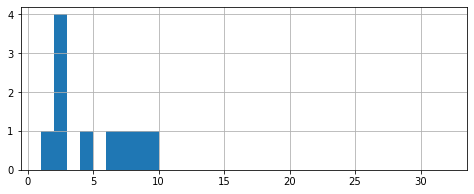

In [12]:
Results.loc[Results.PlayoffResult=='Champ'].TeamRank.hist(bins=range(1,33),xlabelsize=10,figsize=(8,3))

In [ ]:
#Results.to_csv('NFL_Simulation_Results.csv')